### Obtained Perplexity: -8.41, Coherence: 0.31, Best Number of Topics= 60

In [1]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2013.csv')
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [4]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [5]:
df

,year,Post
0,2013,"Depression and Money, Some Real TalkDepression..."
1,2013,What Being Alone and Scared in a Paris Airport...
2,2013,Being Ok with Not Being Ok: The Process I Use ...
3,2013,Being Judged in Diversity WorkBeing Judged in ...
4,2013,DENVER bound!! #RoadTrip2013DENVER bound!! #Ro...
5,2013,Change is Rapid but Recovery GradualChange is ...
6,2013,"April 13, 2013 — LeggyApril 13, 2013 — Leggy C..."
7,2013,How I Cured My AnxietyHow I Cured My Anxiety M...
8,2013,Reflecting on ProjectingReflecting on Projecti...
9,2013,An Entire Human Life Cycle As Dictated By Quor...


In [6]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [7]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [8]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['depression', 'and', 'money', 'some', 'real', 'talkdepression', 'and', 'money', 'some', 'real', 'talk', 'this', 'is', 'the', 'first', 'in', 'series', 'of', 'conversations', 'about', 'depression', 'and', 'money', 'logan', 'sachon', 'so', 'we', 're', 'here', 'today', 'to', 'talk', 'about', 'depression', 'and', 'how', 'it', 'affects', 'our', 'money', 'martha', 'kaplan', 'not', 'well', 'it', 'has', 'what', 'would', 'characterize', 'as', 'negative', 'effect', 'ls', 'yes', 'think', 'you', 'are', 'right', 'about', 'that', 'we', 'both', 'have', 'some', 'personal', 'experience', 'with', 'this', 'say', 'mk', 'would', 'say', 'that', 'also', 'ls', 'so', 'we', 're', 'going', 'to', 'talk', 'about', 'this', 'martha', 'kaplan', 'is', 'not', 'your', 'real', 'name', 'though', 'maybe', 'it', 'should', 'be', 'mk', 'yes', 'have', 'requested', 'to', 'be', 'anonymous', 'because', 'of', 'my', 'job', 'it', 'hard', 'to', 'be', 'taken', 'seriously', 'in', 'your', 'place', 'of', 'business', 'if', 'it', 'widely'

In [9]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [10]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [11]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['depression', 'and', 'money', 'some', 'real', 'talkdepression', 'and', 'money', 'some', 'real', 'talk', 'this', 'is', 'the', 'first', 'in', 'series', 'of', 'conversations', 'about', 'depression', 'and', 'money', 'logan', 'sachon', 'so', 'we', 're', 'here', 'today', 'to', 'talk', 'about', 'depression', 'and', 'how', 'it', 'affects', 'our', 'money', 'martha', 'kaplan', 'not', 'well', 'it', 'has', 'what', 'would', 'characterize', 'as', 'negative', 'effect', 'ls', 'yes', 'think', 'you', 'are', 'right', 'about', 'that', 'we', 'both', 'have', 'some', 'personal', 'experience', 'with', 'this', 'say', 'mk', 'would', 'say', 'that', 'also', 'ls', 'so', 'we', 're', 'going', 'to', 'talk', 'about', 'this', 'martha', 'kaplan', 'is', 'not', 'your', 'real', 'name', 'though', 'maybe', 'it', 'should', 'be', 'mk', 'yes', 'have', 'requested', 'to', 'be', 'anonymous', 'because', 'of', 'my', 'job', 'it', 'hard', 'to', 'be', 'taken', 'seriously', 'in', 'your', 'place', 'of', 'business', 'if', 'it', 'widely',

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [13]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

# 1. Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

# 2. Create Dictionary needed for topic modelling
id2word = corpora.Dictionary(data_lemmatized)

# 3. Create Corpus
texts = data_lemmatized

# 4. Term Document Frequency and Create a bag of words
bow_corpus = bow(dictionary=id2word, processed_docs=texts)

# 5. Calculate low_tfidf_words
# Keep only words with tfidf ranking <= x * len(dictionary)
x = 0.2
total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)

# 6. Filter out least frequently used words
no_below = 0.01
keep_n = 10000
dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
                                                 no_below, keep_n)

# 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)

# 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# created after least frequently and most commonly used words were filtered out.
corpus = bow(dict_tfidf_filtered, texts)

# View
[[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
num_topics = 12
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

[['depression', 'money', 'real', 'talkdepression', 'money', 'real', 'talk', 'first', 'series', 'conversation', 'depression', 'money', 'logan', 'sachon', 'today', 'talk', 'depression', 'affect', 'money', 'martha', 'kaplan', 'well', 'characterize', 'negative', 'effect', 'think', 'right', 'personal', 'experience', 'say', 'mk', 'say', 'also', 'go', 'talk', 'martha', 'kaplan', 'real', 'name', 'maybe', 'mk', 'request', 'anonymous', 'job', 'hard', 'take', 'seriously', 'place', 'business', 'widely', 'know', 'lady', 'sometimes', 'trouble', 'get', 'bed', 'problematic', 'combination', 'disastrous', 'mk', 'give', 'breakdown', 'issue', 'probably', 'always', 'somewhere', 'depression', 'spectrum', 'get', 'particularly', 'bad', 'college', 'week', 'long', 'period', 'sophomore', 'year', 'really', 'leave', 'room', 'mean', 'get', 'food', 'occasionally', 'mostly', 'go', 'class', 'definitely', 'wash', 'hair', 'really', 'see', 'people', 'probably', 'part', 'shame', 'state', 'unwashed', 'hair', 'maybe', 'righ

There are 3181 unique words in the dictionary, 3181 remain after filtering out lest frequent.
2685 remain after filtering out most commonly used words based on tfidf scores.


In [15]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"serve" + 0.013*"cry" + 0.010*"bed" + 0.010*"sister" + 0.010*"forget" '
  '+ 0.010*"scream" + 0.010*"sob" + 0.010*"ok" + 0.006*"suppose" + '
  '0.006*"hit"'),
 (1,
  '0.014*"mk" + 0.011*"pay" + 0.010*"medication" + 0.009*"money" + '
  '0.009*"therapist" + 0.008*"sometimes" + 0.008*"buy" + 0.007*"bed" + '
  '0.007*"therapy" + 0.006*"sad"'),
 (2,
  '0.019*"strength" + 0.013*"fall" + 0.011*"happiness" + 0.008*"strong" + '
  '0.008*"amy" + 0.008*"gym" + 0.008*"mindfulness" + 0.008*"physical" + '
  '0.006*"thinking" + 0.006*"forward"'),
 (3,
  '0.012*"project" + 0.010*"photo" + 0.010*"past" + 0.009*"digital" + '
  '0.008*"game" + 0.007*"thurston" + 0.007*"schedule" + 0.006*"baseball" + '
  '0.006*"social_media" + 0.006*"detox"'),
 (4,
  '0.023*"accept" + 0.019*"partner" + 0.011*"behaviour" + 0.009*"relationship" '
  '+ 0.009*"choose" + 0.006*"fence" + 0.006*"death" + 0.005*"difficult" + '
  '0.005*"meet" + 0.005*"influence"'),
 (5,
  '0.018*"result" + 0.012*"feedback" + 0.012*

In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.815754949489952


In [40]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41526107011509783


In [41]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [42]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9994,"mk, pay, medication, money, therapist, sometim...","[depression, money, real, talkdepression, mone..."
1,1,9.0,0.9987,"worker, pilbara, rio, union, paris, travel, to...","[alone, scared, paris, airport, teach, alone, ..."
2,2,6.0,0.9980,"ok, accept, recognize, strong, action, breathi...","[ok, process, accept, statebee, ok, ok, proces..."
3,3,5.0,0.7754,"result, feedback, test, assessment, cultural_c...","[judge, diversity, workbee, judge, diversity, ..."
4,4,1.0,0.9972,"mk, pay, medication, money, therapist, sometim...","[denver, bind, roadtrip, denver, bind, roadtri..."


In [43]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9994,"mk, pay, medication, money, therapist, sometim...","[depression, money, real, talkdepression, mone..."
1,1,9.0,0.9987,"worker, pilbara, rio, union, paris, travel, to...","[alone, scared, paris, airport, teach, alone, ..."
2,2,6.0,0.9980,"ok, accept, recognize, strong, action, breathi...","[ok, process, accept, statebee, ok, ok, proces..."
3,3,5.0,0.7754,"result, feedback, test, assessment, cultural_c...","[judge, diversity, workbee, judge, diversity, ..."
4,4,1.0,0.9972,"mk, pay, medication, money, therapist, sometim...","[denver, bind, roadtrip, denver, bind, roadtri..."
5,5,4.0,0.9981,"accept, partner, behaviour, relationship, choo...","[change, rapid, recovery, gradualchange, rapid..."
6,6,7.0,0.9929,"dog, alive, worried, cancer, guy, somehow, wor...","[april, leggyapril, leggy, college, turn, imag..."
7,7,10.0,0.9991,"extrovert, god, introvert, fun, food, social, ...","[cure, anxietyhow, cure, anxiety, first, panic..."
8,8,3.0,0.9984,"project, photo, past, digital, game, thurston,...","[reflect, projecting, projection, happen, comm..."
9,9,1.0,0.9395,"mk, pay, medication, money, therapist, sometim...","[entire, human, life, cycle, dictate, quora, r..."


In [55]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

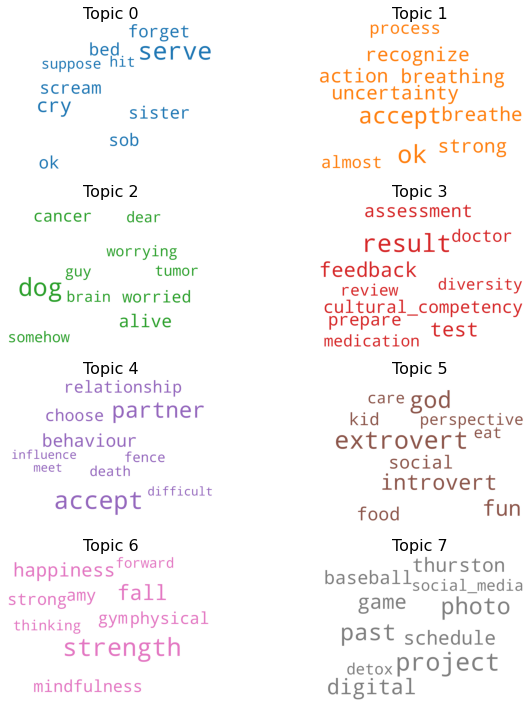

In [44]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [45]:
df_dominant_topic.to_csv("Medium2013.csv")

In [21]:
topic_words = []
for i in range(num_topics):
    tt = lda_model.get_topic_terms(i,10)
    topic_words.append([id2word[pair[0]] for pair in tt])
    
df2=pd.DataFrame({'Year':[],'Source':[],'Topic_ID':[],'Most_freq_words':[]})
df2['Most_freq_words']=topic_words
df2 = df2.assign(Year=2014)
df2 = df2.assign(Source='Medium')
print(df2.shape)
ls=[]
for i in range(0,num_topics):
    ls.append(i)
df2['Topic_ID']=ls
df2

(12, 4)


,Year,Source,Topic_ID,Most_freq_words
0,2014,Medium,0,"[serve, cry, bed, sister, forget, scream, sob,..."
1,2014,Medium,1,"[mk, pay, medication, money, therapist, someti..."
2,2014,Medium,2,"[strength, fall, happiness, strong, amy, gym, ..."
3,2014,Medium,3,"[project, photo, past, digital, game, thurston..."
4,2014,Medium,4,"[accept, partner, behaviour, relationship, cho..."
5,2014,Medium,5,"[result, feedback, test, assessment, cultural_..."
6,2014,Medium,6,"[ok, accept, recognize, strong, action, breath..."
7,2014,Medium,7,"[dog, alive, worried, cancer, guy, somehow, wo..."
8,2014,Medium,8,"[age, difficult, client, elder, attempt, guilt..."
9,2014,Medium,9,"[worker, pilbara, rio, union, paris, travel, t..."


In [23]:
df2.to_csv("topic_words_m2013.csv")

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=100, step=6)


26


(8, 0.0702457038615133, 0.28957036620578425)

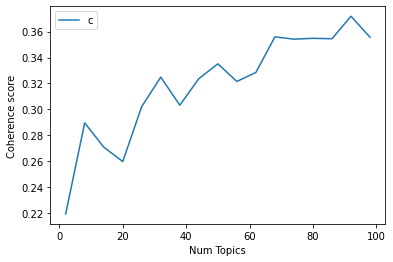

In [21]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
print(x[4])
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)